### decompose


- 5.24早修改table format 空格\xa
- 5.24 下午修改str_normalize 
- 5.24 晚 72需要复查
- 5.25 早list query strip() 
- 5.27 修改total，尝试disambiguous/  改成PIPE  / 晚上发现列名重复修改的问题， 发现shot来自test的问题
- 5.29 在shot中添加extra
- 5.31 在选列aug的shot中添加extra
- 6.1 some extra infor may be useful
- 6.3 添val 101shot

In [1]:
import sys
sys.path.append('/media/disk1/chatgpt/zh/tabular_data')

In [2]:
import pandas as pd
from utils import parse_specific_composition, add_row_number, parse_specific_composition_zh
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI, OpenAI
from data_loader import TableFormat, TableLoader
from langchain.memory import ChatMessageHistory
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from sqlalchemy import create_engine
from executor import SQLManager
import sqlparse
embeddings = HuggingFaceBgeEmbeddings(
            model_name='BAAI/bge-large-en',
            model_kwargs={'device': 'cuda:0', 'trust_remote_code': True},
            encode_kwargs={'normalize_embeddings': True})

In [3]:
from langchain.prompts.prompt import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from data_loader import TableFormat
query_examples = [
                  "what was the time difference between the first place finisher and the eighth place finisher?",
                  "other than william stuart price, which other businessman was born in tulsa?",
                  "which canadian city had the most passengers traveling from manzanillo international airport in 2013?"
                  ]
new_query_examples = [
                      "what was the time for the first place finisher?; what was the time for the eighth place finisher?",
                      "was william stuart price born in tulsa?; who was born in tulsa?",
                      "how many passengers do each airline from canadian city have?; which canadian city had the most passengers?"
                      ]
num_k = 3
inds = [1, 11, 86]
table_loader = TableLoader(table_name='wikitable', split='validation', use_sample=True, small_test=False)
normalised_data = [table_loader.normalize_table(table_loader.dataset[inds[i]]) for i in range(num_k)]
example_samples = [TableFormat(format='none', data=normalised_data[i], save_embedding=True, embeddings=embeddings).get_sample_data(sample_type='embedding', query=normalised_data[i]['query']) for i in range(num_k)]
examples = [TableFormat.format_html(example_samples[i], normalised_data[i]['table']['caption']) for i in range(num_k)]

examples_prompt = PromptTemplate(input_variables=["query", "table", "new_query"], template=
"""Sub-Table: {table}
Query: {query}
Decompose query: {new_query}""")

examples_dict = [{"query": query_examples[i],
                                    "table": examples[i],
                                    "new_query": new_query_examples[i]} for i in range(num_k)]
decompose_prompt_wiki = FewShotPromptTemplate(
    examples=examples_dict,
    example_prompt=examples_prompt,
    prefix="""You are capable of converting complex query into sub queries. Based on the table, decompose original query into at most 2 complete sub queries which can solve original query. Output new query directly.""",
    suffix=
    """Sub-Table: {table}
Query: {query}
Decompose query: """,
    input_variables=["query", "table"],
)



In [4]:
task_name = 'wikitable'
split = 'test'
model_name = 'gpt-3.5-turbo-0125'
# model = ChatOpenAI(model_name=model_name, openai_api_base="https://api.chatanywhere.com.cn/v1",
#                        openai_api_key="sk-WZtqZEeuE0Xb6syVghDgAxdwe0ASWLkQRGxl61UI7B9RqNC4", temperature=0.7).bind(logprobs=True)
schema_information = pd.read_csv(f"../result/aug/{task_name}_{split}_schema.csv", index_col='table_id')
aug_information = pd.read_csv(f"../result/aug/{task_name}_{split}_summary.csv", index_col='table_id')
composition_information = pd.read_csv(f"../result/aug/{task_name}_{split}_composition.csv", index_col='table_id')
engine = create_engine('sqlite:////media/disk1/chatgpt/zh/tabular_data/db/sqlite/wiki_query.db', echo=False)
manager = SQLManager(engine=engine)

In [5]:
table_loader = TableLoader(table_name=task_name, split='test', use_sample=False, small_test=False)
sample = table_loader.normalize_table(table_loader.dataset[2])

### disambiguous

In [6]:
from langchain.prompts.prompt import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from data_loader import TableFormat
inds = [5, 11, 46]
num_k = 3
table_loader = TableLoader(table_name='wikitable', split='validation', use_sample=True, small_test=False)
normalised_data = [table_loader.normalize_table(table_loader.dataset[inds[i]]) for i in range(num_k)]
example_samples = [TableFormat(format='none', data=normalised_data[i], save_embedding=True,embeddings=embeddings).get_sample_data(sample_type='embedding', query=normalised_data[i]['query']) for i in range(num_k)]
examples = [TableFormat.format_html(example_samples[i], normalised_data[i]['table']['caption']) for i in range(num_k)]
new_query_examples = ["was the Sandia Peak Tramway before or after the 3S Aerial Tramway in terms of Year_of_inauguration?",
                      "other than William Stuart Price, which other businessman's was in Tulsa in terms of Hometown?",
                      "How many players are G\\nF in terms of Position?"]
examples_prompt = PromptTemplate(input_variables=["query", "new_query"], template=
"""
Query: {query}
Table: {table}
New query: {new_query}""")

examples_dict = [{"query": table_loader.dataset[inds[i]]['question'],
                  "table": examples[i],
                    "new_query": new_query_examples[i]} for i in range(num_k)]
disambiguous_prompt_wiki = FewShotPromptTemplate(
    examples=examples_dict,
    example_prompt=examples_prompt,
    # prefix="""Based on the given table, your task is to rewrite the query to resolve ambiguity and ensure the question is consistent with the table. 
    # This requires pinpointing elements of the question to table contents and rewriting the question to ensure a consistent, clear interpretation. """,
    suffix=
    """
Query: {query}
Table: {table}
New query: """,
    input_variables=["query", "table"],
)

### step-back

In [7]:
from langchain.prompts.prompt import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from data_loader import TableFormat
inds = [11, 182, 70]
num_k = 2
table_loader = TableLoader(table_name='wikitable', split='validation', use_sample=True, small_test=False)
normalised_data = [table_loader.normalize_table(table_loader.dataset[inds[i]]) for i in range(num_k)]
example_samples = [TableFormat(format='none', data=normalised_data[i], save_embedding=True,embeddings=embeddings).get_sample_data(sample_type='embedding', query=normalised_data[i]['query']) for i in range(num_k)]
examples = [TableFormat.format_html(example_samples[i], normalised_data[i]['table']['caption']) for i in range(num_k)]
new_query_examples = [
    # "Which country uses the US dollar as its currency and has the Federal Reserve as its central bank?",
    "which business man was born in tulsa?",
    "what is the network owned by national polytechnic institute?",
    "what districts are more populous than haridwar?"
    ]
examples_prompt = PromptTemplate(input_variables=["query", "new_query"], template=
"""
Query: {query}
Table: {table}
New query: {new_query}""")

examples_dict = [{"query": table_loader.dataset[inds[i]]['question'],
                  "table": examples[i],
                    "new_query": new_query_examples[i]} for i in range(num_k)]
step_back_prompt_wiki = FewShotPromptTemplate(
    examples=examples_dict,
    example_prompt=examples_prompt,
    prefix="""Based on the table, your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer.""",
    suffix=
    """
Query: {query}
Table: {table}
New query: """,
    input_variables=["query", "table"],
)

In [8]:
def get_k_shot_with_answer(k: int=1):
#     sqls = ["SELECT COUNT(*) FROM DF WHERE Outcome = 'Runner-up' AND Opponent = 'Roger Federer';"
#             ]
#     thoughts = ["The SQL query filters the data to only include rows where the outcome is 'Runner-up' and the opponent is 'Roger Federer'. The sub-table shows that Roger Federer was a runner-up 2 times."]
#     tables = [""" <table>
# <thead>
# <tr><th>  COUNT(*)</th></tr>
# </thead>
# <tbody>
# <tr><td>2.0000    </td></tr>
# </tbody>
# </table>"""]
#     tables_pipe = ["""/*
# table caption : turkish cup
# col : MAX(winners_c_from_previous_round)
# row 1: 54
# */"""]
#     claims = ["how many times was roger federer a runner-up?"]
        sqls = ["SELECT DISTINCT Type FROM DF WHERE Type != 'audio';"
                ]
        thoughts = ["Based on the SQL query and the extra information provided, the types include audio or video. Therefore, other than audio, the payload type is video."]
        tables = ['<table>\n<thead>\n<tr><th> Type </th></tr>\n</thead>\n<tbody>\n<tr><td>video   </td></tr>\n<tr><td>audio/video   </td></tr>\n</tbody>\n</table>']
        claims = ["other than audio, what type of payload types are there?"]
        extras = ["The payload types for audio include audio, video, and audio/video."]
#     sqls = ["SELECT MIN(points) FROM DF WHERE rider = 'roger dutton / tony wright';"
#             ]
#     thoughts = ["Based on the SQL query provided, the minimum number of points that Roger Dutton / Tony Wright received in the 1972 Isle of Man TT event was 3. 3 is the fewest points they received. "]
#     tables = ["<table>\n<caption>1972 isle of man tt</caption>\n<thead>\n<tr><th>  MIN(points)</th></tr>\n</thead>\n<tbody>\n<tr><td>3            </td></tr>\n</tbody>\n</table>"]
#     claims = ["2 be the fewest point that roger dutton / tony wright receive"]
    # inds from test split
        examples_prompt = PromptTemplate(input_variables=["SQL", "table", "information",  "claim", "thought", "output"], template=
        """
SQL Excuted: 
```{SQL}```
Sub-table: {table}
Extra information:
{information}

Query: {claim}
Thought: {thought}
Answer: {output}
        """)
        examples_dict = dict(zip(["SQL", "table", "information",  "claim", "thought", "output"], [sqls[0], tables[0], extras[0], claims[0], thoughts[0], 'video']))
        prompt_template = FewShotPromptTemplate(
                examples=[examples_dict],
                example_prompt=examples_prompt,
                prefix="""Below is a sub-table generated by excuting the corresponding SQL. You need to understand the logic behind the SQL filtering. Think step by step and answer the question given in the query.
You should output in the following format:
Thought: your step by step thought
Answer: Only return the concise string instead of other format information. Do not repeat the question.
Below is an example.""",
        suffix=
        """
SQL Excuted: 
```{SQL}```
Sub-table: {table}
Extra information:
{information}

Query: {query}""",
                input_variables=["table", "query", "SQL", "information"],
        )
        return prompt_template

In [9]:
def get_k_shot_with_aug(k: int=2):
    table_loader = TableLoader(table_name='wikitable', split='train', use_sample=True, small_test=False)
    examples_dict = []
    
    examples_dict.extend([{"table": '<table>\n<caption>Hoot Kloot</caption>\n<thead>\n<tr><th> Number</th><th> Title</th><th> Directed_by_</th><th> Released_</th></tr>\n</thead>\n<tbody>\n<tr><td>1  </td><td>"Kloot\'s Kounty"           </td><td>Hawley Pratt  </td><td>1973       </td></tr>\n<tr><td>2  </td><td>"Apache on the County Seat"</td><td>Hawley Pratt  </td><td>1973       </td></tr>\n<tr><td>6  </td><td>"Mesa Trouble"       </td><td>Sid Marcus </td><td>1974       </td></tr>\n</tbody>\n</table>',
                                        "claim": table_loader.dataset[95]['question'],
                                        "aug": "The table contains information about the Hoot Kloot animated series, including the episode number, title, director, and release year. \n1. Number: The episode number in the series \n2. Title: The title of the episode \n3. Directed_by_: The director of the episode \n4. Released_: The release year of the episode",
                                        "linking": "the last title -> Released_, the last title-> Number, title -> Title, sid marcus -> Directed_by_",
                                        "output": "Released_, Number, Title, Directed_by_"}])
    examples_dict.extend([{"table": '<table>\n<caption>1943–44 Chicago Black Hawks season</caption>\n<thead>\n<tr><th>  num</th><th>       Date</th><th>            Visitor</th><th>  Score</th><th>               Home</th><th>  Record</th></tr>\n</thead>\n<tbody>\n<tr><td>14   </td><td>December 5 </td><td>New York Rangers   </td><td>6–7    </td><td>Chicago Black Hawks</td><td>8–6–0   </td></tr>\n<tr><td>40   </td><td>February 26</td><td>Chicago Black Hawks</td><td>3–2    </td><td>Toronto Maple Leafs</td><td>18–18–4 </td></tr>\n<tr><td>31   </td><td>January 29 </td><td>Chicago Black Hawks</td><td>4–3    </td><td>Toronto Maple Leafs</td><td>14–16–1 </td></tr>\n</tbody>\n</table>',
                                        "claim": 'what was the difference in score in the december 19th win?',
                                        "aug": 'The table contains information about the 1943-44 Chicago Black Hawks season, including the date, visitor, score, home team, record, and points for each game. \n1. num: The game number in the season \n2. Date: The date of the game\n3. Vistor: The visiting team\n4. Score: The final score, with the visitor score listed first\n5. Home: The home team\n6. Record: The team win-loss-overtime loss record at the time of the game',
                                        "linking": 'difference in score -> Score, december 19th -> Date',
                                        "output": 'Date, Score'}])
    
    # "The table contains information about the Hoot Kloot animated series, including the episode number, title, director, and release year."
    # "№<The episode number in the series>\nTitle<The title of the episode>\nDirected_by_<The director of the episode>\nReleased_<The release year of the episode>"
    examples_prompt = PromptTemplate(input_variables=["table", "aug","claim", "output", "linking"], template=
    """
    Table: {table}
    Extra information: {aug}
    
    Query: {claim}
    Column linking: {linking}
    Columns: {output}""")
    prompt_template = FewShotPromptTemplate(
        examples=examples_dict,
        example_prompt=examples_prompt,
        prefix=
        """
    Based on the Table below, your task is accurately output columns related to the query or contain useful information about the query. This process involves linking similar words or semantically similar terms to columns in the Table.
    Approach this task as follows:
    Read the query and extra information thoroughly and list every possible link from query term to column in the Table. 
    Then Based on the column linking, output all useful columns at last. Make sure all columns in the link step are included and every column is in the Table.""",
        suffix=
        """
    Table: {table}
    Extra information: {aug}
    
    Query: {claim}""",
        input_variables=["table", "claim", "aug"],
)
    return prompt_template


# def get_k_shot_with_aug(k: int=2):
#     table_loader = TableLoader(table_name='wikitable', split='train', use_sample=True, small_test=False)
#     examples_dict = []
#     examples_dict.extend([{"table": '<table>\n<caption>Hoot Kloot</caption>\n<thead>\n<tr><th> Number</th><th> Title</th><th> Directed_by_</th><th> Released_</th></tr>\n</thead>\n<tbody>\n<tr><td>1  </td><td>"Kloot\'s Kounty"           </td><td>Hawley Pratt  </td><td>1973       </td></tr>\n<tr><td>2  </td><td>"Apache on the County Seat"</td><td>Hawley Pratt  </td><td>1973       </td></tr>\n<tr><td>6  </td><td>"Stirrups and Hiccups"     </td><td>Gerry Chiniquy</td><td>1973       </td></tr>\n</tbody>\n</table>',
#                                         "claim": table_loader.dataset[95]['question'],
#                                         "linking": "the last title -> Released_, the last title-> Number, title -> Title, sid marcus -> Directed_by_",
#                                         "output": "Title, Released_, Number, Directed_by_"}])
#     examples_prompt = PromptTemplate(input_variables=["table", "claim", "output", "linking"], template=
#     """
#     Table: {table}
#     Query: {claim}
#     Column linking: {linking}
#     Columns: {output}""")
#     prompt_template = FewShotPromptTemplate(
#         examples=examples_dict,
#         example_prompt=examples_prompt,
#         prefix=
#         """
#     Based on the Table below, your task is accurately output columns related to the query or contain useful information about the query. This process involves linking similar words or semantically similar terms to columns in the Table.
#     Approach this task as follows:
#     Read the query thoroughly and list every possible link from query term to column in the Table. 
#     Then Based on the column linking, output all useful columns at last. Make sure all columns in the link step are included and every column is in the Table.""",
#     # You are a brilliant table executor with the capabilities information retrieval, table parsing, table partition and semantic understanding who can understand the structural information of the table.
#     # Given the following table and query, you should output columns related to the query or contain useful information about the query. 
#     # Here are some examples:""",
#         suffix=
#         """
#     Table: {table}
#     Extra information: {aug}
    
#     Query: {claim}""",
#         input_variables=["table", "claim", "aug"],
# )
#     return prompt_template


In [10]:
# import os
# from langchain_openai import AzureChatOpenAI
# from utils import parse_output
# table_loader = TableLoader(table_name='wikitable', split='train', use_sample=True, small_test=False)
# summary_information = pd.read_csv(f"../result/aug/{task_name}_{split}_summary.csv", index_col='table_id')
# schema_information = pd.read_csv(f"../result/aug/{task_name}_{split}_schema.csv", index_col='table_id')
# composition_information = pd.read_csv(f"../result/aug/{task_name}_{split}_composition.csv", index_col='table_id')


# sample = table_loader.normalize_table(table_loader.dataset[110])

# # summary_aug, column_aug = summary_information.loc[sample['table']['id']]['summary'], summary_information.loc[sample['table']['id']]['column_description'] 
# # col_names, col_infos = parse_output(column_aug, pattern=r'([^<]*)<([^>]*)>')
# # extra_col_info = []
# # for i_c in range(len(col_names)):
# #     extra_col_info.append(f'{i_c + 1}. {col_names[i_c]}: {col_infos[i_c]}')
# formatter = TableFormat(format='none', data=sample)



# llm_chain = LLMChain(llm=model, prompt=get_k_shot_with_aug(), verbose=True)
# batch_pred = llm_chain.batch([{
#     "claim": sample['query'],
#     'aug':  '',
#     # "query": "how many of the seasons games were played in the gold coast convention centre?",
#                             "table": TableFormat.format_html(data= formatter.get_sample_data(sample_type='random',k=5, query=sample['query'],),table_caption=sample['table']['caption'])}],)
# print(batch_pred[0]['text'])
#     #                             "table": """table caption : 2008 - 09 nbl season. 

In [11]:
from utils import parse_output
def scene_A(query, sample, k =3, verbose=True):
    # Our ultimate goal is to answer query based on the original table. Below we have a sub-table with rows randomly sampled from the original table, you are required to infer the data distribution and format from the sample data of the sub-table. Carefully analyze the query, based on the extra information, write a SQLITE3 SELECT SQL statement using table DF that complete query. Directly Output SQL, do not add other string.
    # Our ultimate goal is to answer query based on the original table. Now we have a sub-table with rows randomly sampled from the original table, you are required to infer the data distribution and format from the sample data of the sub-table. Carefully analyze the query, based on the augmentation information, write a SQLITE3 SELECT SQL statement using table DF that complete query. Directly Output SQL, do not add other string.
#     row_instruction = PromptTemplate(input_variables=["table", "claim", "aug"], 
#                                  template="""Our ultimate goal is to answer query based on the original table. Below we have a sub-table with rows randomly sampled from the original table, you are required to infer the data distribution and format from the sample data of the sub-table. Carefully analyze the query, based on the extra information, write a SQLITE3 SELECT SQL statement using table DF that complete query. Directly Output SQL, do not add other string.
# sub-table: {table}
# Extra information: {aug}

# Query: {claim}
# SQL: """)
    row_instruction = PromptTemplate(input_variables=["table", "claim", "aug"], 
                                    template="""Our ultimate goal is to answer query based on the original table. Now we have a sub-table with rows randomly sampled from the original table, you are required to infer the data distribution and format from the sample data of the sub-table. Carefully analyze the query, based on the augmentation information, write a SQLITE3 SELECT SQL statement using table DF that complete query. Directly Output SQL, do not add other string.
sub-table: {table}
Extra information: {aug}

Query: {claim}
SQL: """)
    formatter = TableFormat(format='none', data=sample, save_embedding=True, embeddings=embeddings)
    k_shot_prompt = get_k_shot_with_aug()
    formatter.normalize_schema(schema_information.loc[sample['table']['id']]['schema'])
    if k == 0:
        sample_data = formatter.get_sample_data(sample_type='head', k=k)
    else:
        sample_data = formatter.get_sample_data(sample_type='embedding', query=query, k=k)
    with get_openai_callback() as cb:
        llm_chain = LLMChain(llm=model, prompt=k_shot_prompt, verbose=verbose)
        summary_aug, column_aug = aug_information.loc[sample['table']['id']]['summary'], aug_information.loc[sample['table']['id']]['column_description'] 
        col_names, col_infos = parse_output(column_aug, pattern=r'([^<]*)<([^>]*)>')
        extra_col_info = []
        for i_c in range(len(col_names)):
            extra_col_info.append(f'{i_c + 1}. {col_names[i_c]}: {col_infos[i_c]}')
        
        stage_1_batch_pred = llm_chain.batch([dict({'table': TableFormat.format_html(data=sample_data, table_caption=sample['table']['caption']),
                                            'claim': query,
                                            'aug':  summary_aug +'\n'+ '\n'.join(extra_col_info)
                                            })], return_only_outputs=True)[0]['text']
        if verbose:
            print(stage_1_batch_pred)
        stage_1_batch_pred = stage_1_batch_pred.split(':')[-1]
        
        extra_cols = formatter.get_sample_column(embeddings, column_aug)
        # stage 2: SQL generation
        llm_chain = LLMChain(llm=model, prompt=row_instruction, verbose=verbose)
        columns = list(set([c.strip() for c in stage_1_batch_pred.split(',')] + extra_cols))
        try: 
            # formatter.all_data = formatter.all_data.loc[:, columns]
            sample_data = add_row_number(sample_data.loc[:, columns])
        except:
            sample_data = add_row_number(sample_data)
        extra_information = []
        tuples = parse_specific_composition_zh(composition_information.loc[sample['table']['id']]['composition'], sample_data.columns)
        for col, com in tuples:
            if len(pd.unique(formatter.all_data[col])) < 6:
                com += f' (Values like {", ".join(list(formatter.all_data[col].dropna().unique().astype(str)))})'
                extra_information.append(col + ':' + com)
            else:
                com += f' (Values like {", ".join(list(formatter.all_data[col].dropna().unique()[:3].astype(str)))}...)'
                extra_information.append(col + ':' + com)
        extra_information.append('row_number: row index in the original table')
        stage_2_batch_pred = llm_chain.batch([dict({'table': TableFormat.format_html(data = sample_data, table_caption=sample['table']['caption']),
                                            'claim': query,
                                            'aug':  summary_aug + '\nColumn information:\n' + '\n'.join(extra_information)
                                            })], return_only_outputs=True)[0]['text'].replace("–", "-").replace("—", "-").replace("―", "-").replace("−", "-")
        if verbose:
            print(stage_2_batch_pred)
    # stage 3: SQL Excution
    try: 
        execute_data = manager.execute_from_df(stage_2_batch_pred, add_row_number(formatter.all_data), table_name='DF')
    except:
        execute_data = formatter.all_data
        stage_2_batch_pred = 'SELECT * from DF;'
    if len(execute_data) == 0:
        return query, stage_2_batch_pred, 'No data from database', cb.total_tokens
    return query, stage_2_batch_pred, TableFormat.format_html(data=execute_data), cb.total_tokens
    # return query, stage_2_batch_pred, execute_data, cb.total_tokens

In [12]:
import concurrent.futures
from langchain_community.callbacks import get_openai_callback
def parallel_run(func, args_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = [executor.submit(func, arg) for arg in args_list]
        return [future.result() for future in concurrent.futures.as_completed(results)]

def parallel_run_kwargs(func, args_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(lambda kwargs: func(**kwargs), args_list)
        return list(results)

### RUN

In [13]:
def eval_blury_string(pred_list):
    pred_label = []
    for pred in pred_list:
        predict_ans = pred.split('\n')[-1]
        if '0' in predict_ans:
            predict_ans = '0'
        elif '1' in predict_ans:
            predict_ans = '1'
        else:
            predict_ans = '2'
        pred_label.append(predict_ans)
    return pred_label

In [14]:
import concurrent.futures
from typing import List
import os
import json
from langchain_community.callbacks import get_openai_callback
def parallel_run(func, args_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = [executor.submit(func, arg) for arg in args_list]
        return [future.result() for future in concurrent.futures.as_completed(results)]

def parallel_run_kwargs(func, args_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(lambda kwargs: func(**kwargs), args_list)
        return list(results)

def save_csv(input_list: List[List], label_list: List, file_path):
    import pandas as pd
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    assert len(input_list) == len(label_list)
    df = pd.DataFrame()
    for i in range(len(label_list)):
        df[label_list[i]] = pd.Series(input_list[i])
    if os.path.exists(file_path) and file_path.endswith('.csv'):
        df_origin = pd.read_csv(file_path)
        df = pd.concat([df_origin, df], axis=0)
    df.to_csv(file_path, index=False, encoding='utf-8')

## 调整extrainformation的位置

In [15]:
from utils import parse_output
answer_instruction = PromptTemplate(input_variables=["SQL", "table", "claim"], 
                                    template="""
Below is a sub-table generated by excuting the corresponding SQL. You need to understand the logic behind the SQL filtering and answer the query using the final sub-table. 
SQL Excuted: 
```{SQL}```
Sub-table: 
{table}
Query: {claim}
Please provide a clear, complete statement in response to the query. If you cannot answer the query based on the sub-table, just say 'Cannot get answer from sub-table'.
""" )
def scene_B(query, sample, k=3, verbose=False):
    row_instruction = PromptTemplate(input_variables=["table", "claim", "aug"], 
                                 template="""Our ultimate goal is to answer query based on the original table. Now we have a sub-table with rows sampled from the original table, you are required to infer the data distribution and format from the sample data of the sub-table. Carefully analyze the query, based on the extra information, write a SQLITE3 SELECT SQL statement using table DF that complete query. Directly Output SQL, do not add other string.
sub-table: {table}
Extra information: {aug}

Query: {claim}
SQL: """)
    
    formatter = TableFormat(format='none', data=sample, save_embedding=True, embeddings=embeddings)
    formatter.normalize_schema(schema_information.loc[sample['table']['id']]['schema'])
    if k == 0:
        sample_data = formatter.get_sample_data(sample_type='head', k=k)
    else:
        sample_data = formatter.get_sample_data(sample_type='embedding', query=query, k=k)
    # get columns
    with get_openai_callback() as cb:
        llm_chain = LLMChain(llm=model, prompt=get_k_shot_with_aug(), verbose=verbose)
        summary_aug, column_aug = aug_information.loc[sample['table']['id']]['summary'], aug_information.loc[sample['table']['id']]['column_description'] 
        col_names, col_infos = parse_output(column_aug, pattern=r'([^<]*)<([^>]*)>')
        extra_col_info = []
        for i_c in range(len(col_names)):
            extra_col_info.append(f'{i_c + 1}. {col_names[i_c]}: {col_infos[i_c]}')
        stage_1_batch_pred = llm_chain.batch([dict({'table': TableFormat.format_html(data=sample_data, table_caption=sample['table']['caption']),
                                            'claim': query,
                                            'aug':  summary_aug + '\n' + '\n'.join(extra_col_info)
                                            })], return_only_outputs=True)[0]['text']
        stage_1_batch_pred = stage_1_batch_pred.split(':')[-1]
        
        extra_cols = formatter.get_sample_column(embeddings, column_aug)
        # stage 2: SQL generation
        llm_chain = LLMChain(llm=model, prompt=row_instruction, verbose=verbose)
        columns = list(set([c.strip() for c in stage_1_batch_pred.split(',')] + extra_cols))
        try: 
            sample_data = add_row_number(sample_data.loc[:, columns])
        except:
            sample_data = add_row_number(sample_data)
        extra_information = []
        tuples = parse_specific_composition_zh(composition_information.loc[sample['table']['id']]['composition'], sample_data.columns)
        for col, com in tuples:
            if len(pd.unique(formatter.all_data[col])) < 6:
                com += f' (Values like {", ".join(list(formatter.all_data[col].dropna().unique().astype(str)))})'
                extra_information.append(col + ':' + com)
            else:
                com += f' (Values like {", ".join(list(formatter.all_data[col].dropna().unique()[:3].astype(str)))}...)'
                extra_information.append(col + ':' + com)
        #  sample augmentation
        # extra_information = (parse_specific_composition(composition_information.loc[sample['table']['id']]['composition'], sample_data.columns))
        extra_information.append('row_number: row index in the table')
        stage_2_batch_pred = llm_chain.batch([dict({'table': TableFormat.format_html(data=sample_data, table_caption=sample['table']['caption']),
                                            'claim': query,
                                            'aug':  summary_aug + '\n Column information:' + '\n'.join(extra_information)
                                            })], return_only_outputs=True)[0]['text'].replace("–", "-").replace("—", "-").replace("―", "-").replace("−", "-")
    
        
        # stage 3: SQL Excution
        try: 
            execute_data= manager.execute_from_df(stage_2_batch_pred, add_row_number(formatter.all_data), table_name='DF')
        except:
            execute_data = formatter.all_data
            stage_2_batch_pred = 'SELECT * from DF;'
        llm_chain = LLMChain(llm=model, prompt=answer_instruction, verbose=verbose)
        response = llm_chain.batch([dict({'table': TableFormat.format_html(execute_data),
                                                'claim': query,
                                                'SQL':  stage_2_batch_pred
                                                })], return_only_outputs=True)[0]['text']
    # print("total_tokens:", cb.total_tokens)
    return response, cb.total_tokens

In [16]:
from langchain_openai import AzureChatOpenAI
import os


os.environ["AZURE_OPENAI_API_KEY"] = "2b219db0d2984f9dae28b651ab8ab3d9"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://smsh.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-02-01"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-35-turbo"

# os.environ["AZURE_OPENAI_API_KEY"] = "0c75de50975e4f278b882fe90da47f2f"
# os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ces.openai.azure.com"
# os.environ["AZURE_OPENAI_API_VERSION"] = "2024-02-01"
# os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-35-turbo"
model = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
    temperature=0.3,
    max_retries=5, request_timeout=600
)


In [17]:
a

NameError: name 'a' is not defined

In [26]:
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI, OpenAI
import datetime
from FlagEmbedding import FlagReranker
from openai import BadRequestError
from tqdm.notebook import tqdm
# table_loader = TableLoader(table_name='wikitable', split='validation', use_sample=True, small_test=False)
table_loader = TableLoader(table_name='wikitable', split='test', use_sample=False, small_test=False)
# model = ChatOpenAI(model_name='gpt-3.5-turbo-0125', openai_api_base="https://api.chatanywhere.com.cn/v1",
#                        openai_api_key="sk-bLZSHx4pKfPRZkYyIyyvUHSEjrlqj5sh2QIsxOM23yJnyoGD", temperature=0.01)
save_path = f"../result/final_answer/wikitable_{datetime.datetime.now().strftime('%m-%d_%H-%M-%S')}.csv"
# save_path = f"../result/final_answer/wikitable_06-02_01-52-48.csv"

# reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True)

muilti_answer_instruction = PromptTemplate(input_variables=["information", "claim"], 
# template="""You are a brilliant table executor with the capabilities information retrieval, table parsing, table partition and semantic understanding who can understand the structural information of the table.
template = """
Below is a sub-table generated by excuting the corresponding SQL. You need to understand the logic behind the SQL filtering. Complete task with the help of extra information below.

SQL Excuted: 
```{SQL}```
Sub-table:
{table}
Extra information:
{information}

Query: {query}
Think step by step and answer the last question given in the query. Only return the string instead of other format information. Do not repeat the question.
""" )
sample_k = 3
# Task: answer the last question given in the query. Only return the string instead of other format information. Do not repeat the question.
# Task: verify whether the provided claim/query is true or false, return 0 if it's false, or 1 if it's true. Please think step by step and return 0/1 at last.


# muilti_answer_instruction = get_k_shot_with_answer()
# for sample_n in range(3):
tokens = []
outputs = []
labels = []
ids = []
extra_quries = []
i = 435
# with tqdm(total=len(table_loader.dataset) - 0, desc=f"Processing",ncols=1500) as pbar:
#     while i < len(table_loader.dataset):
#         try:
sample = table_loader.normalize_table(
                    table_loader.dataset[i])
all_tokens = 0
all_queries = []
formatter = TableFormat(format='none', data=sample, save_embedding=False)
sample_data = formatter.get_sample_data(sample_type='random', k=sample_k, query=sample['query'])
with get_openai_callback() as cb:
    llm_chain = LLMChain(llm=model, prompt=step_back_prompt_wiki, verbose=True)
    batch_pred = llm_chain.batch([{"query": sample['query'], "table": TableFormat.format_html(sample_data)}], return_only_outputs=True)
    if batch_pred[0]['text'].strip() != sample['query']:
        all_queries.append(batch_pred[0]['text'].strip())
        print(batch_pred)
    llm_chain = LLMChain(llm=model, prompt=decompose_prompt_wiki, verbose=True)
    batch_pred = llm_chain.batch([{"query": sample['query'], "table": TableFormat.format_html(sample_data)}], return_only_outputs=True)
    all_queries.extend([q.strip() for q in batch_pred[0]['text'].split(';')])
    # print(all_queries)
all_tokens += cb.total_tokens
all_queries = list(set(all_queries))
args_list = [{"query": q, "sample": sample, "k": sample_k} for q in all_queries]
# print(args_list)
ans_from_B = parallel_run_kwargs(scene_B, args_list)
results = [res[0] for res in ans_from_B if 'Cannot get answer from sub-table' not in res[0] ]
all_tokens += sum([res[1] for res in ans_from_B])
#With answer
results= []
with get_openai_callback() as cb:
    imp_input = scene_A(sample['query'], sample, sample_k, False)
    llm_chain = LLMChain(llm=model, prompt=get_k_shot_with_answer(), verbose=True)
    batch_pred = llm_chain.batch([{"query": sample['query'],"SQL": imp_input[1], "table": imp_input[2], "information": '\n'.join(results)}], return_only_outputs=True)
# print(batch_pred[0])
all_tokens += cb.total_tokens
# print('ALL TOKENS', all_tokens)
ids.append(sample['id'])
labels.append(sample['query'])
outputs.append(batch_pred[0]['text'])
tokens.append(all_tokens)
extra_quries.append(';'.join(all_queries))
        #     if (i + 1) % 10 == 0:
        #             print(f'saving {i}')
        #             save_csv([outputs, labels, ids, tokens, extra_quries], ['preds', 'statements','ids', 'tokens', 'extra'], file_path=save_path)
        #             outputs = []
        #             labels = []
        #             ids = []
        #             tokens = []
        #             extra_quries = []
        #     i += 1
        #     print(f' Process {i}')
        #     pbar.update(1)
        
        # except BadRequestError as e:
        #     print('*************************Bad Request**************')
        #     i += 1
        #     pbar.update(1)
        # except ValueError as e:
        #     print(f'******************Value Error {i}****************************')
        #     i += 1
        #     pbar.update(1)

    





> Entering new LLMChain chain...
Prompt after formatting:
Based on the table, your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer.


Query: other than william stuart price, which other businessman was born in tulsa?
Table: <table>
<caption>Oklahoma State Regents for Higher Education</caption>
<thead>
<tr><th>                Name</th><th>  Profession</th><th>  Hometown</th><th>  Term_Expires</th><th>  Office</th></tr>
</thead>
<tbody>
<tr><td>William Stuart Price</td><td>Businessman </td><td>Tulsa     </td><td>2013          </td><td>        </td></tr>
<tr><td>Joseph L. Parker Jr.</td><td>Businessman </td><td>Tulsa     </td><td>2014          </td><td>Chair   </td></tr>
<tr><td>Bill W. Burgess Jr. </td><td>Attorney    </td><td>Lawton    </td><td>2011          </td><td>        </td></tr>
</tbody>
</table>
New query: which business man was born in tulsa?


Query: what is the only network owned by national polytechnic institut

In [27]:
batch_pred

[{'text': "Thought: The SQL query is counting the total number of rows where the film is 'Two and a Half Men'. Each row represents an award (nominations and wins) for the show.\nAnswer: 12.0000"}]

In [ ]:
batch_pred

[{'text': 'Thought: The SQL query filters the hospitals where the number of hospital beds is equal to 6. From the sub-table, we can see that the only hospital with 6 hospital beds is Vidant Bertie Hospital.\nAnswer: Vidant Bertie Hospital'}]

In [ ]:
for i in range(100):
    print(i, table_loader.normalize_table(table_loader.dataset[i])['query'] )

0 which country had the most cyclists finish within the top 10?
1 how many people were murdered in 1940/41?
2 how long did it take for the new york americans to win the national cup after 1936?
3 alfie's birthday party aired on january 19. what was the airdate of the next episode?
4 what is the number of 1st place finishes across all events?
5 in which competition did hopley finish fist?
6 what is the total number of films with the language of kannada listed?
7 what was the number of people attending the toros mexico vs. monterrey flash game?
8 what time period had no shirt sponsor?
9 when was his first 1st place record?
10 in which three consecutive years was the record the same?
11 does pat or john have the highest total?
12 what is the combined score of year end rankings before 2009?
13 how many more ships were wrecked in lake huron than in erie?
14 what is the only character with a blank c string?
15 what was the total number of points scored by the tide in the last 3 games combine

In [ ]:
show_table(table_loader.normalize_table(table_loader.dataset[18]) ).to_csv('18.csv')

NameError: name 'show_table' is not defined

In [19]:
all_queries

['which hospital has 6 hospital beds?',
 'how many hospital beds does each hospital have?']

In [ ]:

def show_table(data, execute=False):
    formatter = TableFormat(format='none', data=data)
    print(data['id'])
    print(data['query'])
    print(formatter.format_psql())
    # print(preds[i])
    # print(SQLs[i])
    # test_df = manager.execute_from_df(SQLs[i], formatter.all_data)
    # print(test_df)
    print(data['label'])
    return formatter.all_data

show_table(table_loader.normalize_table(table_loader.dataset[i]) )
# show_table(table_loader.normalize_table(table_loader.dataset[2039]) )

nu-99
where is saint anslem school located?
+-------------------------------------------------+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+
| District                                        | Location                                      | Communities_served                                                                                                                     |
|-------------------------------------------------+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------|
| Agape Christian Academy                         | Burton Township, Ohio and Troy Township, Ohio | Accepts applications prior to the start of each school year                                                                            |
| Hawken

In [ ]:
scene_B('what are the robots in the middle east?', sample, 3, True)




> Entering new LLMChain chain...
Prompt after formatting:

    Based on the Table below, your task is accurately output columns related to the query or contain useful information about the query. This process involves linking similar words or semantically similar terms to columns in the Table.
    Approach this task as follows:
    Read the query and extra information thoroughly and list every possible link from query term to column in the Table. 
    Then Based on the column linking, output all useful columns at last. Make sure all columns in the link step are included and every column is in the Table.


    Table: <table>
<caption>Hoot Kloot</caption>
<thead>
<tr><th> Number</th><th> Title</th><th> Directed_by_</th><th> Released_</th></tr>
</thead>
<tbody>
<tr><td>1  </td><td>"Kloot's Kounty"           </td><td>Hawley Pratt  </td><td>1973       </td></tr>
<tr><td>2  </td><td>"Apache on the County Seat"</td><td>Hawley Pratt  </td><td>1973       </td></tr>
<tr><td>6  </td><td>"Mesa T

('Cannot get answer from sub-table.', 1884)

In [ ]:
save_csv([outputs, labels, ids, tokens, extra_quries], ['preds', 'statements','ids', 'tokens', 'extra'], file_path=save_path)

In [ ]:
all_queries

['what is the number of hospital beds for each hospital?',
 'which hospital has 6 hospital beds?']

In [ ]:
outputs

['Thought: The SQL query is counting the number of instances where the League Cup is equal to the FA Cup. The count is 11, so there are 11 people who have the same amount of League Cups as FA Cups.\nAnswer: 11']

In [ ]:
scene_B('what are the robots in the middle east?', sample, 3, True)



> Entering new LLMChain chain...
Prompt after formatting:

    Based on the Table below, your task is accurately output columns related to the query or contain useful information about the query. This process involves linking similar words or semantically similar terms to columns in the Table.
    Approach this task as follows:
    Read the query and extra information thoroughly and list every possible link from query term to column in the Table. 
    Then Based on the column linking, output all useful columns at last. Make sure all columns in the link step are included and every column is in the Table.


    Table: <table>
<caption>Hoot Kloot</caption>
<thead>
<tr><th> Number</th><th> Title</th><th> Directed_by_</th><th> Released_</th></tr>
</thead>
<tbody>
<tr><td>1  </td><td>"Kloot's Kounty"           </td><td>Hawley Pratt  </td><td>1973       </td></tr>
<tr><td>2  </td><td>"Apache on the County Seat"</td><td>Hawley Pratt  </td><td>1973       </td></tr>
<tr><td>6  </td><td>"Mesa T

('Cannot get answer from sub-table.', 1742)

In [ ]:

def show_table(data, execute=False):
    formatter = TableFormat(format='none', data=data)
    print(data['id'])
    print(data['query'])
    print(formatter.format_psql())
    # print(preds[i])
    # print(SQLs[i])
    # test_df = manager.execute_from_df(SQLs[i], formatter.all_data)
    # print(test_df)
    print(data['label'])

show_table(table_loader.normalize_table(table_loader.dataset[i]) )

nu-4169
how many people have the same amount of league cups are they do fa cups?
+---------------+----------+----------+--------------+-------------+---------+
| Name          |   League |   FA_Cup |   League_Cup |   JP_Trophy |   Total |
|---------------+----------+----------+--------------+-------------+---------|
| Scot Bennett  |        5 |        0 |            0 |           0 |       5 |
| Danny Coles   |        3 |        0 |            0 |           0 |       3 |
| Liam Sercombe |        1 |        0 |            0 |           0 |       1 |
| Alan Gow      |        4 |        0 |            0 |           0 |       4 |
| John O'Flynn  |       11 |        0 |            1 |           0 |      12 |
| Guillem Bauza |        2 |        0 |            0 |           0 |       2 |
| Jimmy Keohane |        3 |        0 |            0 |           0 |       3 |
| Pat Baldwin   |        1 |        0 |            0 |           0 |       1 |
| Jamie Cureton |       20 |        0 |           

In [ ]:
llm_chain = LLMChain(llm=model, prompt=step_back_prompt_wiki, verbose=False)
llm_chain.batch([{"query": sample['query'], "table": TableFormat.format_html(sample_data)}], return_only_outputs=True)

[{'text': 'how many league cups do the people have who have the same amount of league cups as fa cups?'}]

In [ ]:
all_queries

['how many league cups does each person have?',
 'how many fa cups does each person have?',
 'How many league cups do people have the same amount of as FA cups?']

In [ ]:
outputs

['Thought: The SQL query is counting the number of instances where the League Cup is equal to the FA Cup. The count is 11, so there are 11 people who have the same amount of League Cups as FA Cups.\nAnswer: 11']

In [ ]:
##### add residual 

from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI, OpenAI
import datetime
# from FlagEmbedding import FlagReranker
from openai import BadRequestError, RateLimitError
from tqdm.notebook import tqdm
table_loader = TableLoader(table_name='wikitable', split='test', use_sample=False, small_test=False)
model = ChatOpenAI(model_name='gpt-3.5-turbo-0125', openai_api_base="https://api.chatanywhere.tech/v1",
                       openai_api_key="sk-bLZSHx4pKfPRZkYyIyyvUHSEjrlqj5sh2QIsxOM23yJnyoGD", temperature=0.01)
save_path = f"../result/final_answer/wikitable_06-02_01-52-48.csv"
sample_k = 3
data = pd.read_csv(save_path)

tokens = []
outputs = []
labels = []
ids = []
extra_quries = []
i = 0
with tqdm(total=len(table_loader.dataset), desc=f"Processing",ncols=150) as pbar:
    while i < len(table_loader.dataset):
        if table_loader.dataset[i]['id'] in list(data['ids']):
            i += 1
        else:
            try:
                sample = table_loader.normalize_table(
                    table_loader.dataset[i])
                all_tokens = 0
                all_queries = []
                formatter = TableFormat(format='none', data=sample, save_embedding=False)
                sample_data = formatter.get_sample_data(sample_type='random', k=sample_k, query=sample['query'])
                with get_openai_callback() as cb:
                    llm_chain = LLMChain(llm=model, prompt=step_back_prompt_wiki, verbose=False)
                    batch_pred = llm_chain.batch([{"query": sample['query'], "table": TableFormat.format_html(sample_data)}], return_only_outputs=True)
                    if batch_pred[0]['text'].strip() != sample['query']:
                        all_queries.append(batch_pred[0]['text'].strip())
                    # llm_chain = LLMChain(llm=model, prompt=disambiguous_prompt_wiki, verbose=False)
                    # batch_pred = llm_chain.batch([{"query": sample['query'], "table": TableFormat.format_html(sample_data)}], return_only_outputs=True)
                    # all_queries.append(batch_pred[0]['text'].strip())
                    llm_chain = LLMChain(llm=model, prompt=decompose_prompt_wiki, verbose=False)
                    batch_pred = llm_chain.batch([{"query": sample['query'], "table": TableFormat.format_html(sample_data)}], return_only_outputs=True)
                    all_queries.extend([q.strip() for q in batch_pred[0]['text'].split(';')])
                    # print(all_queries)
                all_tokens += cb.total_tokens
                all_queries = list(set(all_queries))
                args_list = [{"query": q, "sample": sample, "k": sample_k} for q in all_queries]
                # print(args_list)
                ans_from_B = parallel_run_kwargs(scene_B, args_list)
                results = [res[0] for res in ans_from_B if 'Cannot get answer from sub-table' not in res[0] ]
                all_tokens += sum([res[1] for res in ans_from_B])
                #With answer
                # results= []
                with get_openai_callback() as cb:
                    imp_input = scene_A(sample['query'], sample, sample_k, False)
                    llm_chain = LLMChain(llm=model, prompt=get_k_shot_with_answer(), verbose=False)
                    batch_pred = llm_chain.batch([{"query": sample['query'],"SQL": imp_input[1], "table": imp_input[2], "information": '\n'.join(results)}], return_only_outputs=True)
                # print(batch_pred[0])
                all_tokens += cb.total_tokens
                # print('ALL TOKENS', all_tokens)
                ids.append(sample['id'])
                labels.append(sample['query'])
                outputs.append(batch_pred[0]['text'])
                tokens.append(all_tokens)
                extra_quries.append(';'.join(all_queries))
                i += 1
                pbar.update(1)
                print(f'process {i}')
            except RateLimitError as e:
                print('*************************Rate limit**************')
                pass
        pbar.update(1)
save_csv([outputs, labels, ids, tokens, extra_quries], ['preds', 'statements','ids', 'tokens', 'extra'], file_path=save_path)
    



Processing:   0%|                                                                                             …

In [ ]:
ids

[]

In [ ]:
len(outputs)

1

In [ ]:
save_csv([outputs, labels, ids, tokens, extra_quries], ['preds', 'statements','ids', 'tokens', 'extra'], file_path=save_path)

In [ ]:
def parse_extra_info(summary_aug, column_aug, composition_aug, columns):
    col_names, col_infos = parse_output(column_aug, pattern=r'([^<]*)<([^>]*)>')
    items, crackets = parse_output(composition_aug, pattern = r'\d. (.+?): (.+)')
    assert len(items) == len(col_names)
    extra_col_info = []
    for i_c in range(len(col_names)):
        if col_names[i_c] in columns:
            extra_col_info.append(f'{i_c + 1}. {col_names[i_c]}: {col_infos[i_c]} {crackets[i_c]}')
            
    extra_col_info.append('row_number: row number in the original table')
    return summary_aug + '\n'.join(extra_col_info)

In [ ]:
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI, OpenAI
import datetime
from FlagEmbedding import FlagReranker
from openai import BadRequestError
from tqdm.notebook import tqdm
# table_loader = TableLoader(table_name='wikitable', split='validation', use_sample=True, small_test=False)
table_loader = TableLoader(table_name='wikitable', split='test', use_sample=False, small_test=False)
# model = ChatOpenAI(model_name='gpt-3.5-turbo-0125', openai_api_base="https://api.chatanywhere.com.cn/v1",
#                        openai_api_key="sk-bLZSHx4pKfPRZkYyIyyvUHSEjrlqj5sh2QIsxOM23yJnyoGD", temperature=0.01)
save_path = f"../result/final_answer/wikitable_{datetime.datetime.now().strftime('%m-%d_%H-%M-%S')}.csv"
# save_path = f"../result/final_answer/wikitable_06-02_01-52-48.csv"

# reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True)

muilti_answer_instruction = PromptTemplate(input_variables=["information", "claim"], 
# template="""You are a brilliant table executor with the capabilities information retrieval, table parsing, table partition and semantic understanding who can understand the structural information of the table.
template = """
Below is a sub-table generated by excuting the corresponding SQL. You need to understand the logic behind the SQL filtering. Complete task with the help of extra information below.

SQL Excuted: 
```{SQL}```
Sub-table:
{table}
Extra information:
{information}

Query: {query}
Think step by step and answer the last question given in the query. Only return the string instead of other format information. Do not repeat the question.
""" )
sample_k = 3
# Task: answer the last question given in the query. Only return the string instead of other format information. Do not repeat the question.
# Task: verify whether the provided claim/query is true or false, return 0 if it's false, or 1 if it's true. Please think step by step and return 0/1 at last.


# muilti_answer_instruction = get_k_shot_with_answer()
# for sample_n in range(3):
tokens = []
outputs = []
labels = []
ids = []
extra_quries = []
i = 89
# with tqdm(total=len(table_loader.dataset) - 0, desc=f"Processing",ncols=1500) as pbar:
#     while i < len(table_loader.dataset):
#         try:
sample = table_loader.normalize_table(
                    table_loader.dataset[i])
all_tokens = 0
all_queries = []
formatter = TableFormat(format='none', data=sample, save_embedding=False)
sample_data = formatter.get_sample_data(sample_type='all', k=sample_k, query=sample['query'])

#With answer
# results= []
prompt = 'Task: Based on the table, answer the last question given in the query. Only return the string instead of other format information. Do not repeat the question.'
answer_instruction = PromptTemplate(input_variables=["table", "claim"], 
                                    template="""
Task: Based on the table, think step by step and answer the last question given in the query. 
Table: {table}
Query: {claim}
""" )
# Task: Based on the table, answer the last question given in the query. Only return the string instead of other format information. Do not repeat the question.
llm_chain = LLMChain(llm=model, prompt=answer_instruction, verbose=True)
batch_pred = llm_chain.batch([{"claim": sample['query'], "table": TableFormat.format_html(formatter.all_data)}], return_only_outputs=True)
# with get_openai_callback() as cb:
#     imp_input = scene_A(sample['query'], sample, sample_k, False)
#     llm_chain = LLMChain(llm=model, prompt=get_k_shot_with_answer(), verbose=True)
#     batch_pred = llm_chain.batch([{"query": sample['query'],"SQL": imp_input[1], "table": imp_input[2], "information": ''}], return_only_outputs=True)
# print(batch_pred[0])

        #     if (i + 1) % 10 == 0:
        #             print(f'saving {i}')
        #             save_csv([outputs, labels, ids, tokens, extra_quries], ['preds', 'statements','ids', 'tokens', 'extra'], file_path=save_path)
        #             outputs = []
        #             labels = []
        #             ids = []
        #             tokens = []
        #             extra_quries = []
        #     i += 1
        #     print(f' Process {i}')
        #     pbar.update(1)
        
        # except BadRequestError as e:
        #     print('*************************Bad Request**************')
        #     i += 1
        #     pbar.update(1)
        # except ValueError as e:
        #     print(f'******************Value Error {i}****************************')
        #     i += 1
        #     pbar.update(1)

    





> Entering new LLMChain chain...
Prompt after formatting:

Task: Based on the table, think step by step and answer the last question given in the query. 
Table: <table>
<thead>
<tr><th>  Rank</th><th>             Nation</th><th>  Gold</th><th>  Silver</th><th>  Bronze</th><th>  Total</th></tr>
</thead>
<tbody>
<tr><td>1     </td><td>Australia (AUS)    </td><td>2     </td><td>1       </td><td>0       </td><td>3      </td></tr>
<tr><td>2     </td><td>Italy (ITA)        </td><td>1     </td><td>1       </td><td>1       </td><td>3      </td></tr>
<tr><td>3     </td><td>Germany (EUA)      </td><td>1     </td><td>0       </td><td>1       </td><td>2      </td></tr>
<tr><td>4     </td><td>Soviet Union (URS) </td><td>1     </td><td>0       </td><td>0       </td><td>1      </td></tr>
<tr><td>5     </td><td>Switzerland (SUI)  </td><td>0     </td><td>2       </td><td>1       </td><td>3      </td></tr>
<tr><td>6     </td><td>United States (USA)</td><td>0     </td><td>1       </td><td>0       </td>

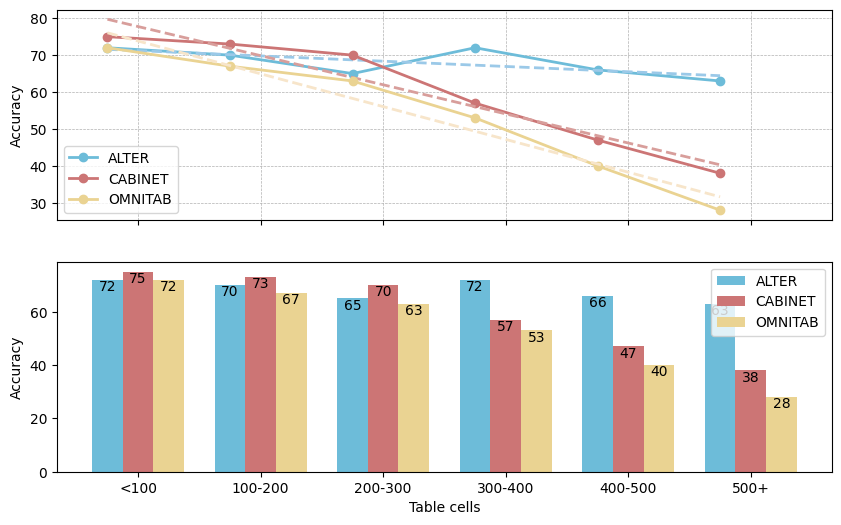

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

categories = ["<100", "100-200", "200-300", "300-400", "400-500", "500+"]
accuracies_1 = [75, 73, 70, 57, 47, 38]
accuracies_ours = [72, 70, 65, 72, 66, 63]
accuracies_2 = [72, 67, 63, 53, 40, 28]
# 将类别转换为数值型数据（1, 2, 3, ...）
categories_numeric = np.arange(1, len(categories) + 1)

# 计算回归线
slope, intercept, r_value, p_value, std_err = stats.linregress(categories_numeric, accuracies_ours)

# 创建一个与categories相同长度的数组，用于绘制回归线
regression_line = slope * categories_numeric + intercept

# 绘制原始折线图
axs[0].plot(categories, accuracies_ours, marker='o', color='#6DBCD9', linestyle='-', linewidth=2, label='ALTER')

# 绘制回归线9BC9E8  C8DCEC
axs[0].plot(categories, regression_line, color='#9BC9E8', linestyle='--', linewidth=2)

slope, intercept, r_value, p_value, std_err = stats.linregress(categories_numeric, accuracies_1)
# 创建一个与categories相同长度的数组，用于绘制回归线
regression_line = slope * categories_numeric + intercept
axs[0].plot(categories, accuracies_1, marker='o', color='#CC7575', linestyle='-', linewidth=2, label='CABINET')
# 绘制回归线
axs[0].plot(categories, regression_line, color='#D89E9B', linestyle='--', linewidth=2)


slope, intercept, r_value, p_value, std_err = stats.linregress(categories_numeric, accuracies_2)
regression_line = slope * categories_numeric + intercept
axs[0].plot(categories, accuracies_2, marker='o', color='#EAD392', linestyle='-', linewidth=2, label='OMNITAB')
axs[0].plot(categories, regression_line, color='#F7E5CA', linestyle='--', linewidth=2)
# 添加虚线网格
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# 添加标题和标签
# axs[0].set_title("Accuracy vs Table cells")
# axs[0].set_xlabel("Table cells")
axs[0].set_ylabel("Accuracy")

# 显示图例
axs[0].legend()


bar_width = 0.25
index = np.arange(len(categories))
rects = axs[1].bar(index, accuracies_ours, color='#6DBCD9', width=bar_width, label='ALTER')
axs[1].bar_label(rects, padding=-10)

rects = axs[1].bar(index + bar_width, accuracies_1, color='#CC7575', width=bar_width, label='CABINET')
axs[1].bar_label(rects, padding=-10)
rects = axs[1].bar(index + 2 * bar_width, accuracies_2, color='#EAD392', width=bar_width, label='OMNITAB')
axs[1].bar_label(rects, padding=-10)
# 绘制对比数据1
# rects = axs[0].bar(index + bar_width, accuracies对比1, color='#C5E3E2', width=bar_width, label='CABINET')
# axs[0].bar_label(rects, padding=3)
# # 绘制对比数据2
# rects = axs[0].bar(index + 2 * bar_width, accuracies对比2, color='#9EC6DB', width=bar_width, label='OMNITAB')
# axs[0].bar_label(rects, padding=3)
# 设置横坐标标签
axs[1].set_xticks(index + bar_width)
axs[1].set_xticklabels(categories)

# 添加标题和标签
# axs[1].set_title("Accuracy vs Table cells")
axs[1].set_xlabel("Table cells")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.show()
# 数据

In [ ]:
# save to pdf
plt.savefig('xxx.pdf', bbox_inches='tight')